In [1]:
import pandas as pd


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
from keras.preprocessing.text import Tokenizer

C:\Users\Divesh\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
from keras.preprocessing.sequence import pad_sequences

In [6]:
from keras.models import Sequential

In [7]:
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM

In [8]:
from keras import utils

In [9]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [10]:
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

In [11]:
import gensim

C:\Users\Divesh\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [12]:
import re

In [13]:
import numpy as np

In [14]:
import os

In [15]:
from collections import Counter

In [16]:
import logging

import `

In [18]:
import pickle

In [19]:
import itertools

In [20]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Divesh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [23]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

In [24]:
print("Dataset size:", len(df))

Dataset size: 1600000


In [25]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [26]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [27]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

Wall time: 948 ms


Text(0.5,1,'Dataset labels distribuition')

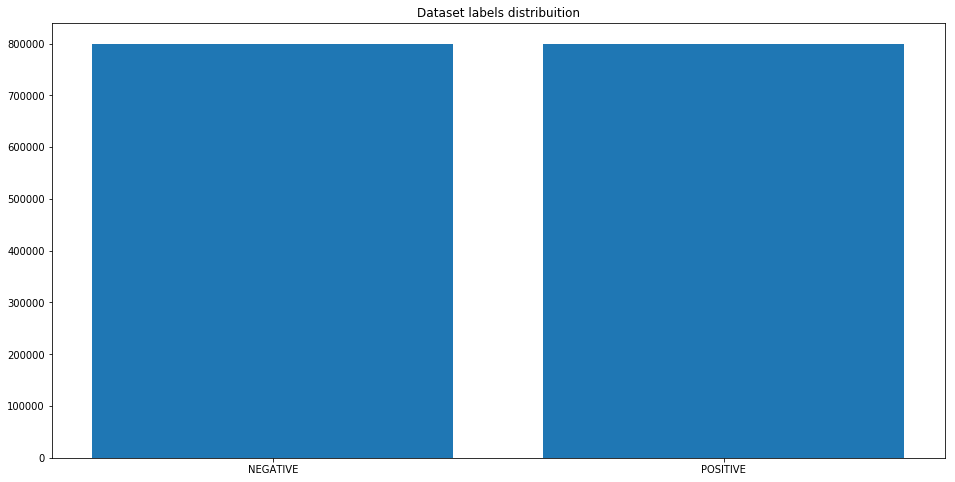

In [28]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [29]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [30]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [31]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

Wall time: 1min 6s


In [32]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [33]:
%%time
documents = [_text.split() for _text in df_train.text] 

Wall time: 4.1 s


In [34]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [35]:
w2v_model.build_vocab(documents)

2019-04-18 12:08:52,468 : INFO : collecting all words and their counts
2019-04-18 12:08:52,468 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-04-18 12:08:52,548 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2019-04-18 12:08:52,576 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2019-04-18 12:08:52,612 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2019-04-18 12:08:52,632 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2019-04-18 12:08:52,668 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2019-04-18 12:08:52,693 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2019-04-18 12:08:52,724 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2019-04-18 12:08:52,740 : INFO : PROGRESS: at s

2019-04-18 12:08:54,505 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2019-04-18 12:08:54,536 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2019-04-18 12:08:54,560 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2019-04-18 12:08:54,581 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2019-04-18 12:08:54,616 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2019-04-18 12:08:54,632 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2019-04-18 12:08:54,668 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2019-04-18 12:08:54,699 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2019-04-18 12:08:54,730 : INFO : PROGRESS: at sentence #800000, processed 577088

In [36]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [37]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2019-04-18 12:08:57,809 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-04-18 12:08:58,972 : INFO : EPOCH 1 - PROGRESS: at 5.22% examples, 402783 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:09:00,005 : INFO : EPOCH 1 - PROGRESS: at 11.51% examples, 448758 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:09:01,041 : INFO : EPOCH 1 - PROGRESS: at 17.78% examples, 466472 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:09:02,129 : INFO : EPOCH 1 - PROGRESS: at 23.84% examples, 464400 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:09:03,232 : INFO : EPOCH 1 - PROGRESS: at 28.61% examples, 441938 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:09:04,270 : INFO : EPOCH 1 - PROGRESS: at 34.57% examples, 446360 words/s, in_qsize 13, out_qsize 2
2019-04-18 12:09:05,313 : INFO : EPOCH 1 - PROGRESS: at 40.08% examples, 444871 words/s, in_qsize 16, out_qsize 0
2019-04-18 12:09:06,340 : INFO : EPOCH 1 - PROGRESS: 

2019-04-18 12:09:50,620 : INFO : EPOCH 4 - PROGRESS: at 5.65% examples, 454822 words/s, in_qsize 13, out_qsize 2
2019-04-18 12:09:51,662 : INFO : EPOCH 4 - PROGRESS: at 12.06% examples, 482697 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:09:52,672 : INFO : EPOCH 4 - PROGRESS: at 18.11% examples, 486654 words/s, in_qsize 14, out_qsize 1
2019-04-18 12:09:53,672 : INFO : EPOCH 4 - PROGRESS: at 24.06% examples, 487221 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:09:54,724 : INFO : EPOCH 4 - PROGRESS: at 30.13% examples, 483690 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:09:55,832 : INFO : EPOCH 4 - PROGRESS: at 36.51% examples, 482712 words/s, in_qsize 16, out_qsize 0
2019-04-18 12:09:56,854 : INFO : EPOCH 4 - PROGRESS: at 42.57% examples, 483365 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:09:57,863 : INFO : EPOCH 4 - PROGRESS: at 48.41% examples, 482562 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:09:58,916 : INFO : EPOCH 4 - PROGRESS: at 54.78% examples, 483958 words/s, 

2019-04-18 12:10:43,624 : INFO : EPOCH 7 - PROGRESS: at 13.58% examples, 359002 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:10:44,652 : INFO : EPOCH 7 - PROGRESS: at 18.43% examples, 366936 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:10:45,661 : INFO : EPOCH 7 - PROGRESS: at 23.42% examples, 374703 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:10:46,664 : INFO : EPOCH 7 - PROGRESS: at 28.72% examples, 384520 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:10:47,680 : INFO : EPOCH 7 - PROGRESS: at 34.68% examples, 398059 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:10:48,732 : INFO : EPOCH 7 - PROGRESS: at 39.86% examples, 399383 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:10:49,742 : INFO : EPOCH 7 - PROGRESS: at 45.16% examples, 402950 words/s, in_qsize 16, out_qsize 0
2019-04-18 12:10:50,756 : INFO : EPOCH 7 - PROGRESS: at 49.48% examples, 397877 words/s, in_qsize 14, out_qsize 1
2019-04-18 12:10:51,779 : INFO : EPOCH 7 - PROGRESS: at 54.24% examples, 396551 words/s,

2019-04-18 12:11:39,937 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-18 12:11:39,949 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-18 12:11:39,953 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-18 12:11:39,969 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-18 12:11:39,969 : INFO : EPOCH - 9 : training on 9227204 raw words (8222962 effective words) took 20.8s, 394455 effective words/s
2019-04-18 12:11:41,000 : INFO : EPOCH 10 - PROGRESS: at 4.02% examples, 326906 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:11:42,048 : INFO : EPOCH 10 - PROGRESS: at 9.23% examples, 368435 words/s, in_qsize 16, out_qsize 1
2019-04-18 12:11:43,066 : INFO : EPOCH 10 - PROGRESS: at 15.08% examples, 402779 words/s, in_qsize 16, out_qsize 1
2019-04-18 12:11:44,137 : INFO : EPOCH 10 - PROGRESS: at 21.14% examples, 417945 words/s, in_qsize 16, out_qsize 0
2019-04-18 12:11:45,224 : INFO : EPOCH 1

2019-04-18 12:12:35,058 : INFO : EPOCH 12 - PROGRESS: at 96.74% examples, 455781 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:12:35,470 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-18 12:12:35,474 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-18 12:12:35,506 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-18 12:12:35,510 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-18 12:12:35,538 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-18 12:12:35,538 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-18 12:12:35,542 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-18 12:12:35,558 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-18 12:12:35,558 : INFO : EPOCH - 12 : training on 9227204 raw words (8223868 effective words) took 18.0s, 457929 effective words/s
2019-04-18 12:12:3

2019-04-18 12:13:26,984 : INFO : EPOCH 15 - PROGRESS: at 69.50% examples, 426312 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:13:28,004 : INFO : EPOCH 15 - PROGRESS: at 73.94% examples, 421537 words/s, in_qsize 16, out_qsize 0
2019-04-18 12:13:29,012 : INFO : EPOCH 15 - PROGRESS: at 79.27% examples, 422190 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:13:30,032 : INFO : EPOCH 15 - PROGRESS: at 84.80% examples, 423650 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:13:31,042 : INFO : EPOCH 15 - PROGRESS: at 90.87% examples, 427737 words/s, in_qsize 14, out_qsize 1
2019-04-18 12:13:32,088 : INFO : EPOCH 15 - PROGRESS: at 96.75% examples, 429471 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:13:32,560 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-18 12:13:32,564 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-18 12:13:32,568 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-18 12:13:32,568 : INFO : work

2019-04-18 12:14:18,804 : INFO : EPOCH 18 - PROGRESS: at 44.94% examples, 447612 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:14:19,816 : INFO : EPOCH 18 - PROGRESS: at 50.67% examples, 449738 words/s, in_qsize 13, out_qsize 2
2019-04-18 12:14:20,864 : INFO : EPOCH 18 - PROGRESS: at 55.32% examples, 441345 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:14:21,911 : INFO : EPOCH 18 - PROGRESS: at 60.19% examples, 435841 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:14:22,905 : INFO : EPOCH 18 - PROGRESS: at 65.61% examples, 436414 words/s, in_qsize 14, out_qsize 1
2019-04-18 12:14:23,960 : INFO : EPOCH 18 - PROGRESS: at 70.48% examples, 432310 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:14:24,956 : INFO : EPOCH 18 - PROGRESS: at 76.66% examples, 437430 words/s, in_qsize 14, out_qsize 1
2019-04-18 12:14:26,017 : INFO : EPOCH 18 - PROGRESS: at 81.56% examples, 433234 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:14:27,031 : INFO : EPOCH 18 - PROGRESS: at 86.32% examples, 430454

2019-04-18 12:15:11,268 : INFO : EPOCH 21 - PROGRESS: at 15.19% examples, 413584 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:15:12,318 : INFO : EPOCH 21 - PROGRESS: at 19.84% examples, 400718 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:15:13,325 : INFO : EPOCH 21 - PROGRESS: at 24.72% examples, 400428 words/s, in_qsize 15, out_qsize 2
2019-04-18 12:15:14,325 : INFO : EPOCH 21 - PROGRESS: at 28.94% examples, 391549 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:15:15,349 : INFO : EPOCH 21 - PROGRESS: at 34.35% examples, 397955 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:15:16,365 : INFO : EPOCH 21 - PROGRESS: at 39.97% examples, 405228 words/s, in_qsize 14, out_qsize 1
2019-04-18 12:15:17,380 : INFO : EPOCH 21 - PROGRESS: at 44.94% examples, 404869 words/s, in_qsize 16, out_qsize 0
2019-04-18 12:15:18,393 : INFO : EPOCH 21 - PROGRESS: at 50.13% examples, 406669 words/s, in_qsize 16, out_qsize 0
2019-04-18 12:15:19,420 : INFO : EPOCH 21 - PROGRESS: at 55.10% examples, 405967

2019-04-18 12:16:09,535 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-04-18 12:16:09,535 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-04-18 12:16:09,551 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-04-18 12:16:09,566 : INFO : EPOCH 23 - PROGRESS: at 99.78% examples, 398953 words/s, in_qsize 2, out_qsize 1
2019-04-18 12:16:09,566 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-04-18 12:16:09,597 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-04-18 12:16:09,613 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-04-18 12:16:09,613 : INFO : EPOCH - 23 : training on 9227204 raw words (8222645 effective words) took 20.6s, 399010 effective words/s
2019-04-18 12:16:10,736 : INFO : EPOCH 24 - PROGRESS: at 5.22% examples, 404479 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:16:11,777 : INFO : EPOCH 24 - PROGRESS: at 10.53% examples, 413612 words/

2019-04-18 12:17:03,377 : INFO : EPOCH 26 - PROGRESS: at 69.29% examples, 394500 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:17:04,389 : INFO : EPOCH 26 - PROGRESS: at 73.94% examples, 393458 words/s, in_qsize 14, out_qsize 1
2019-04-18 12:17:05,417 : INFO : EPOCH 26 - PROGRESS: at 79.16% examples, 394809 words/s, in_qsize 16, out_qsize 0
2019-04-18 12:17:06,480 : INFO : EPOCH 26 - PROGRESS: at 84.80% examples, 397288 words/s, in_qsize 16, out_qsize 0
2019-04-18 12:17:07,484 : INFO : EPOCH 26 - PROGRESS: at 89.13% examples, 394998 words/s, in_qsize 16, out_qsize 0
2019-04-18 12:17:08,504 : INFO : EPOCH 26 - PROGRESS: at 93.69% examples, 393468 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:17:09,512 : INFO : EPOCH 26 - PROGRESS: at 98.25% examples, 392365 words/s, in_qsize 16, out_qsize 0
2019-04-18 12:17:09,760 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-04-18 12:17:09,768 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-04-18 12

2019-04-18 12:17:55,760 : INFO : EPOCH 29 - PROGRESS: at 24.06% examples, 386543 words/s, in_qsize 16, out_qsize 0
2019-04-18 12:17:56,844 : INFO : EPOCH 29 - PROGRESS: at 29.59% examples, 392380 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:17:57,900 : INFO : EPOCH 29 - PROGRESS: at 34.67% examples, 393070 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:17:58,899 : INFO : EPOCH 29 - PROGRESS: at 40.41% examples, 402521 words/s, in_qsize 13, out_qsize 2
2019-04-18 12:17:59,947 : INFO : EPOCH 29 - PROGRESS: at 45.92% examples, 406109 words/s, in_qsize 14, out_qsize 1
2019-04-18 12:18:00,981 : INFO : EPOCH 29 - PROGRESS: at 50.67% examples, 403460 words/s, in_qsize 15, out_qsize 1
2019-04-18 12:18:02,021 : INFO : EPOCH 29 - PROGRESS: at 56.62% examples, 409567 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:18:03,025 : INFO : EPOCH 29 - PROGRESS: at 61.39% examples, 408109 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:18:04,040 : INFO : EPOCH 29 - PROGRESS: at 66.80% examples, 410321

2019-04-18 12:18:48,470 : INFO : EPOCH - 31 : training on 9227204 raw words (8223183 effective words) took 18.9s, 434042 effective words/s
2019-04-18 12:18:49,490 : INFO : EPOCH 32 - PROGRESS: at 5.21% examples, 425210 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:18:50,546 : INFO : EPOCH 32 - PROGRESS: at 10.53% examples, 418853 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:18:51,589 : INFO : EPOCH 32 - PROGRESS: at 16.27% examples, 430141 words/s, in_qsize 14, out_qsize 1
2019-04-18 12:18:52,621 : INFO : EPOCH 32 - PROGRESS: at 22.33% examples, 443327 words/s, in_qsize 14, out_qsize 1
2019-04-18 12:18:53,661 : INFO : EPOCH 32 - PROGRESS: at 28.18% examples, 447170 words/s, in_qsize 14, out_qsize 1
2019-04-18 12:18:54,765 : INFO : EPOCH 32 - PROGRESS: at 33.38% examples, 436696 words/s, in_qsize 16, out_qsize 0
2019-04-18 12:18:55,770 : INFO : EPOCH 32 - PROGRESS: at 39.00% examples, 440155 words/s, in_qsize 15, out_qsize 0
2019-04-18 12:18:56,801 : INFO : EPOCH 32 - PROGRESS: at 

Wall time: 10min 9s


(263124774, 295270528)

In [38]:
w2v_model.most_similar("love")

C:\Users\Divesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-04-18 12:19:07,773 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5684652328491211),
 ('loves', 0.557991623878479),
 ('loved', 0.5358697175979614),
 ('adore', 0.505211353302002),
 ('amazing', 0.49776819348335266),
 ('looove', 0.4813362658023834),
 ('loveee', 0.4602011442184448),
 ('awesome', 0.44988957047462463),
 ('lovee', 0.4404873251914978),
 ('miss', 0.42342984676361084)]

In [39]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
Wall time: 30.5 s


In [40]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

Wall time: 45.1 s


In [41]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [42]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [43]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [44]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [45]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [46]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [47]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          87125700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 87,286,201
Trainable params: 160,501
Non-trainable params: 87,125,700
_________________________________________________________________


In [48]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [49]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
 482304/1152000 [===========>..................] - ETA: 9:29:24 - loss: 0.5237 - acc: 0.7369

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [ ]:
predict("I love the music")

In [ ]:
predict("I hate the rain")

In [ ]:
predict("i don't know what i'm doing")

In [ ]:
predict("awesome, I miss my flight")

In [ ]:
predict("pleasure, to meet you")